# Analysis of locus variation across mtb complex

These methods were used to analyse the RD900 locus. Assumes the sequence region chosen as reference is the 'complete' version relative to the others. Will not detect insertions.

## How to make a reference sequence for a region in the genome

* go to the genbank nucelotide record for the genome e.g. https://www.ncbi.nlm.nih.gov/nuccore/FR878060.1?report=graph
* click on the Graphics view
* find your region. you can search by gene but it may not always work
* download the fasta and genbank files from the download button on the left. use 'visible range'
* you may have to rename the fasta file header to work nicely with snpgenie, make it something short. also rename the LOCUS and ACCESSION names in the genbank file to match this.

### example for the MAF file used here:

```
>MAF_TBD1 GM041182
CTGGTTCGGATCGGCACCGCGCGCGATGGTGATTCAGGTTCGCGGCCGCCGGGTACCCGCTCGCGCGGTC
CTTGCTGGGCACTACGCGGCATGGCTGGTGGTTTCGGTGATCGTTGCCTGGATGGTGCTGTCATGACTCC
CTCGACATCGGATGCCAGGTCGCGCCGACGCTCGGCGGAGCCCTTCCTGTGGCTGCTGTTCAGCGCCGGG


LOCUS       MAF_TBD1                5756 bp    DNA     linear   BCT 03-APR-2015
DEFINITION  Mycobacterium africanum GM041182 TBD1 locus.
ACCESSION   MAF_TBD1 REGION: 1764053..1769808
```

## find SNPs (snpgenie)

* align samples to a suitable reference locus e.g. MAF TBD1
* call variants
* build tree from snps

## find region deletions 

* use same alignments as above to calculate coverage across the locus
* or view in IGV

## Links

* [MAF GM041182 genome](https://www.ncbi.nlm.nih.gov/nuccore/FR878060.1?report=graph)

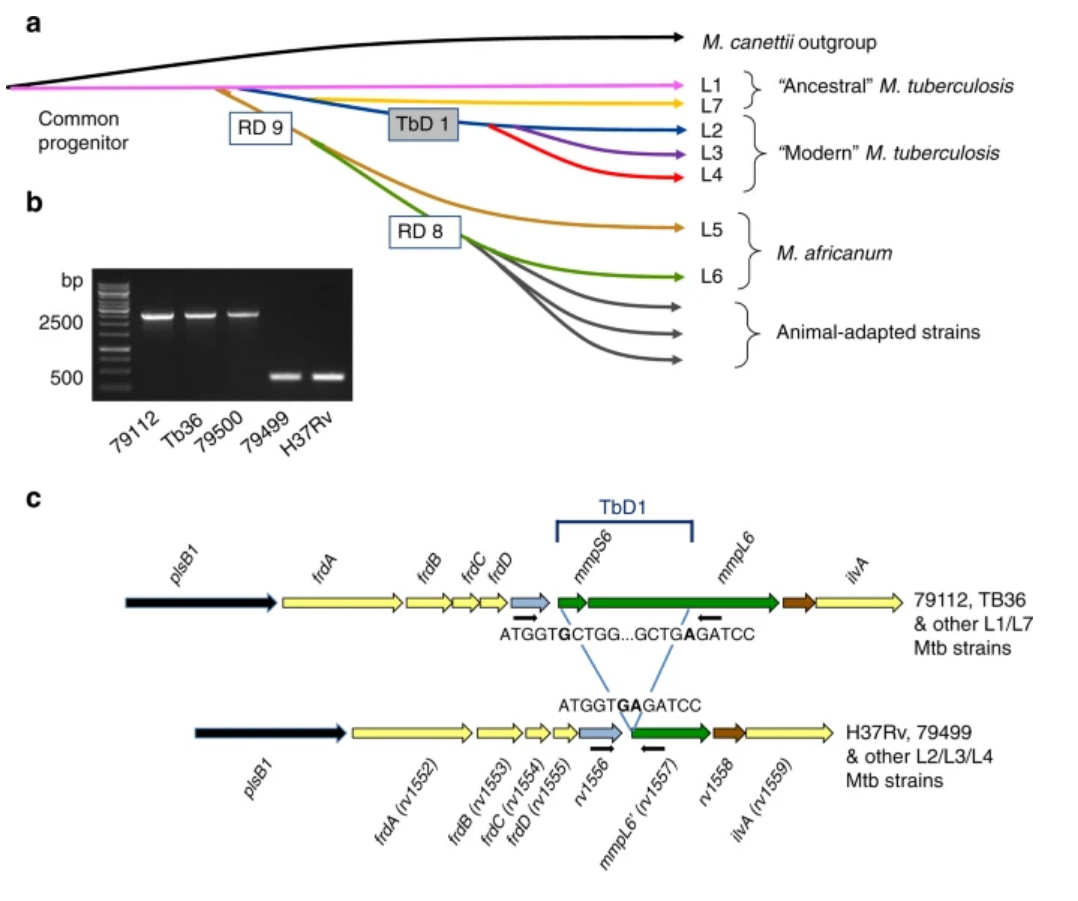

In [2]:
from IPython.display import Image
Image(filename = "tbd1_locus.png", width=600)

In [3]:
import os, glob, subprocess
from importlib import reload
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from snpgenie import tools, aligners, app, trees, plotting

In [18]:
read_data = pd.read_csv('../genomes_data.csv')
path = '/storage/elena_data'
read_data[-5:]

,ACCESSION,PAIRED,LINEAGE,ORIGIN,BIOPROJECT,BIOSAMPLE,Reads lenght (bp),LINK1,LINK2,REFERENCE
58,SRR7983756,yes,BCG-Danish,NaN,PRJNA494982,SAMN10219708,100,NaN,NaN,Borgers et al. 2019
59,ERR766257,yes,BCG-Pasteur,NaN,PRJEB8560,SAMEA3257671,100,NaN,NaN,King Abdullah University of Science and Techno...
60,ERR766251,yes,BCG-Japan,NaN,PRJEB8560,SAMEA3257669,100,NaN,NaN,King Abdullah University of Science and Techno...
61,ERR766266,yes,BCG-Russia,NaN,PRJEB8560,SAMEA3257674,100,NaN,NaN,King Abdullah University of Science and Techno...
62,ERR766254,yes,BCG-Moreau,NaN,PRJEB8560,SAMEA3257670,100,NaN,NaN,King Abdullah University of Science and Techno...


## load locus features

In [5]:
rec = list(SeqIO.parse('MAF_GM041182_TBD1.gb',format='gb'))[0]
#remove gene features for plotting
rec.features = [f for f in rec.features if f.type!='gene' ]
#rec.features

## run snpgenie against reference sequence

In [ ]:
args = {'threads':20, 'outdir': 'snpgenie_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'MAF_GM041182_TBD1.fa', 'gb_file':'MAF_GM041182_TBD1.gb',
        'overwrite':False,
        'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35'
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [19]:
samples = pd.read_csv('snpgenie_results/summary.csv')
samples = samples.merge(read_data,left_on='sample',right_on='ACCESSION')
samples = samples.sort_values('LINEAGE')

# snps

In [20]:
c = app.read_csq_file('snpgenie_results/csq.tsv')
#include only snps or also indels?
c=c[c.snp_type!='synonymous']
muts = list(c.aa.dropna().unique())
#muts

In [21]:
X=pd.read_csv('snpgenie_results/csq.matrix')
X = X[X.aa.isin(muts)]
X=X.set_index(['gene','aa','start']).sort_index()

labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
X=X.rename(columns=labelmap)
X

M. canetti STB-A  M. tuberculosis L2  BCG-Russia  M. tuberculosis L5  M. microti  M. canetti STB-K-S  M. canetti STB-K-R  M. tuberculosis L7  M. tuberculosis L4  \
gene      aa        start                                                                                                                                                                     
MAF_15820 11R>11Q   609                   0                   0           0                   0           0                   0                   0                   0                   0   
          188L>188V 1139                  0                   0           0                   0           0                   1                   1                   0                   0   
MAF_15850 146A>146V 5117                  0                   0           0                   1           0                   0                   0                   0                   0   
          32Q>32E   4774                  0                   0           0                   0           0                   1                   1                   0                   0   
          64Q>64E   4870                  1                   0           0                   0           0                   1                   1                   0                   0   
          98T>98A   4972                  0                   0           0                   0           0                   1                   1                   0                   0   
frdD      10S>10P   160                   1                   0           0                   0           0                   1                   1                   0                   0   
          15A>15V   176                   0                   0           0                   0           0                   1                   1                   0                   0   
          62V>62A   317                   0                   0           0                   0           0                   0                   0                   0                   0   
ilvA      103R>103H 5469                  0                   0           0                   0           0                   0                   0                   0                   0   
          19G>19R   5216                  0                   0           0                   0           0                   0                   0                   0                   0   
mmpL6     101R>101S 2068                  1                   0           0                   0           0                   0                   0                   0                   0   
          13H>13D   1804                  0                   0           0                   0           0                   0                   0                   0                   0   
          13H>13Y   1804                  0                   0           0                   0           0                   1                   1                   0                   0   
          143N>143D 2194                  0                   0           0                   0           0                   0                   0                   0                   0   
          275A>275S 2590                  0                   0           0                   0           0                   0                   0                   0                   0   
          279A>279G 2603                  0                   0           0                   0           0                   0                   0                   0                   0   
          280Q>280E 2605                  0                   0           0                   0           0                   0                   0                   0                   0   
          290Y>290F 2636                  0                   0           0                   0           0                   0                   0                   0                   1   
          291R>2

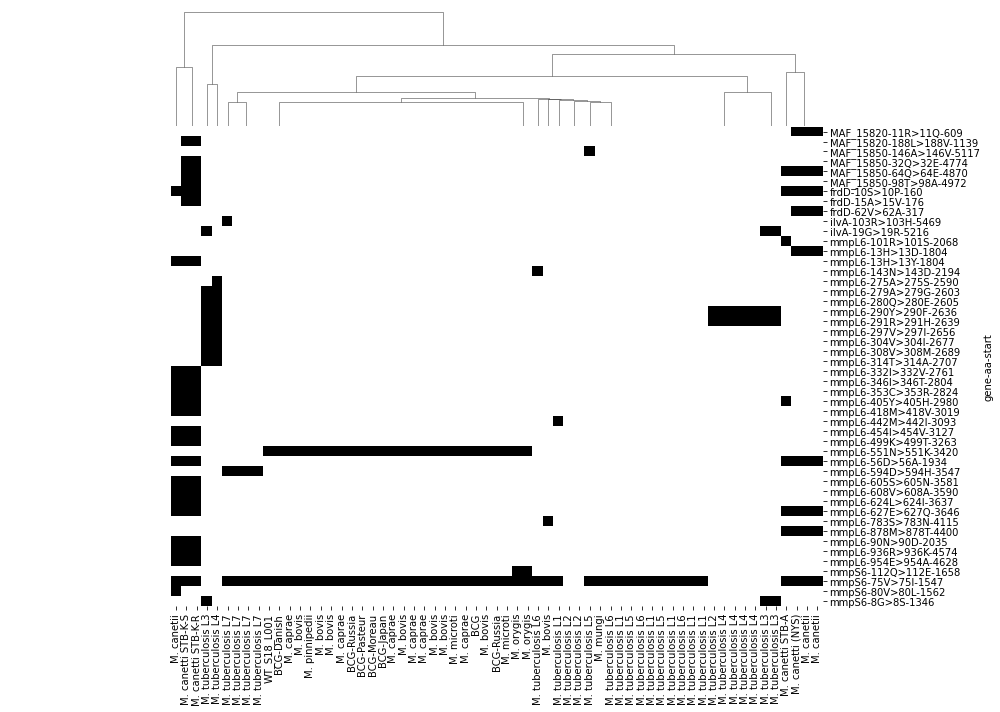

In [22]:
cm=sns.clustermap(X,row_cluster=False,cmap='gray_r',figsize=(14,10),
                  xticklabels=True,yticklabels=True)
cm.cax.set_visible(False)

## phylogeny based on snps

In [10]:
trees.run_RAXML('snpgenie_results/core.fa',outpath='temp')

raxmlHPC-PTHREADS -f a -N 10 -T 8 -m GTRCAT -V -p 14036413 -x 49491550 -n variants -w /home/farrell/gitprojects/mtbc_analyses/tbd1/temp -s snpgenie_results/core.fa


'/home/farrell/gitprojects/mtbc_analyses/tbd1/temp/RAxML_bipartitions.variants'

In [ ]:
reload(trees)
colormap = trees.colors_from_labels(samples,'ACCESSION','LINEAGE')
labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
tree,ts = trees.create_tree('temp/RAxML_bestTree.variants',None,labelmap,colormap)
names=['M. canetti STB-K-S','M. canetti STB-K-R']
trees.remove_nodes(tree, names)

ts.scale = 5000
#ts.mode = 'c'
ts.margin_left = 10
ts.branch_vertical_margin = 1
#ts.force_topology = True
tree.render('%%inline',tree_style=ts,w=400)

# detect deletions

We can do this visually or automate it

In [23]:
def get_region_coverage(bam_file, chr, start, end):
    """Get coverage from bam file at specified region"""

    import pysam
    if bam_file is None or not os.path.exists(bam_file):
        return
    samfile = pysam.AlignmentFile(bam_file, "r")
    vals = [(pileupcolumn.pos, pileupcolumn.n) for pileupcolumn in samfile.pileup(chr, start, end)]
    df = pd.DataFrame(vals,columns=['pos','coverage'])
    df = df[(df.pos>=start) & (df.pos<=end)]
    #fill with zeroes if there is no data at ends
    if df.pos.max() < end:
        new = pd.DataFrame({'pos':range(df.pos.max(), end)})
        new['coverage'] = 0
        df = df.append(new).reset_index(drop=True)
    return df

#get_region_coverage('snpgenie_results/mapped/ERR015598.bam','MAF_TBD1',1,1000)

## show coverage

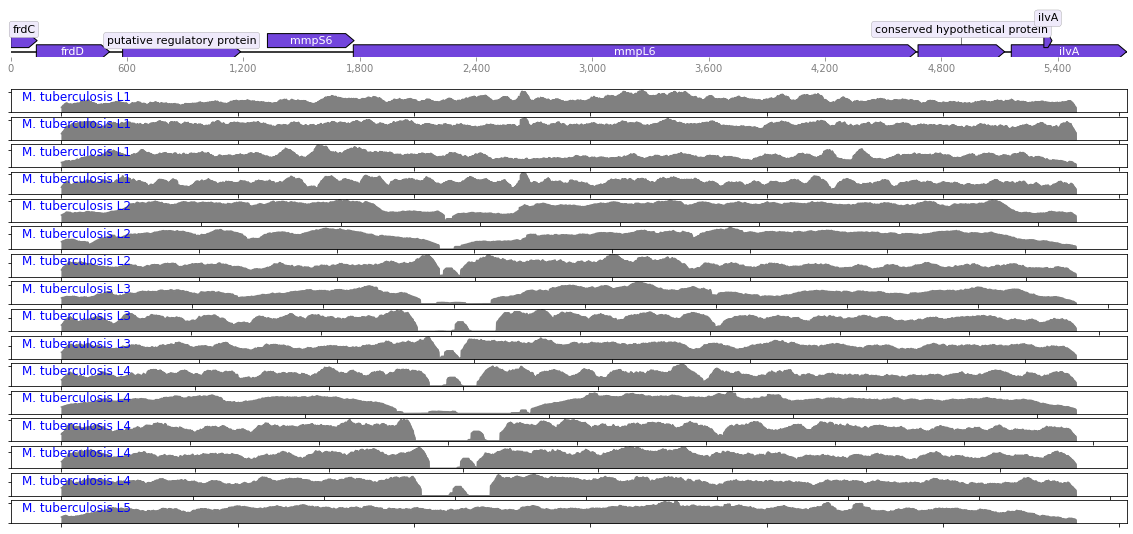

In [28]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

graphic_record = BiopythonTranslator().translate_record(rec)
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20,10))
gs = GridSpec(20, 1, figure=fig)
ax1=fig.add_subplot(gs[:2,0])
graphic_record.plot(ax=ax1)
i=3
for n,r in list(samples.iterrows())[36:52]:
    ax=fig.add_subplot(gs[i,0])
    df = get_region_coverage(r.bam_file,'MAF_TBD1',1,len(rec.seq))
    bins=range(0,max(df.coverage),int(max(df.coverage)/10))
    df['binned']=np.searchsorted(bins, df.coverage.values)
    df.plot(y='coverage',ax=ax,kind='area',color='gray',legend=False)
    ax.text(.01,.5,r.LINEAGE,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    i+=1
#plt.tight_layout()

## automatically detect deletions

In [25]:
def detect_coverage(file, ref):
    """get the average sequencing depth"""
    
    from io import StringIO
    from pyfaidx import Fasta
    cmd = 'zcat %s | paste - - - - | cut -f2 | wc -c' %file
    tmp = subprocess.check_output(cmd,shell=True)
    rg = Fasta(ref)
    avdepth = int(tmp)*2/len(rg)
    #print (avdepth)
    cmd = 'samtools coverage --min-BQ 0 %s' %file
    #print (cmd)
    tmp = subprocess.check_output(cmd,shell=True)
    s = pd.read_csv(StringIO(tmp.decode()),sep='\t')   
    #s['ratio'] = s.meandepth/avdepth
    #print (s)
    return s

detect_coverage('snpgenie_results/mapped/ERR015598.bam','MAF_GM041182_TBD1.fa')


,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
0,MAF_TBD1,1,5756,12751,5756,100,79.619,23.3,59.4


In [26]:
ref='MAF_GM041182_TBD1.fa'
res=[]
for i,r in samples.iterrows():
    c = detect_coverage(r.bam_file, ref)
    c['name'] = r.LINEAGE
    res.append(c)
res=pd.concat(res).reset_index()

In [27]:
print (res)

    index    #rname  startpos  endpos  numreads  covbases  coverage  meandepth  meanbaseq  meanmapq                name
0       0  MAF_TBD1         1    5756      4116      5756     100.0    69.1181       34.7      59.3                 BCG
1       0  MAF_TBD1         1    5756      1601      5756     100.0    55.1525       35.7      57.8          BCG-Danish
2       0  MAF_TBD1         1    5756      6004      5756     100.0   100.3020       32.6      59.5           BCG-Japan
3       0  MAF_TBD1         1    5756      4874      5756     100.0    79.4454       32.8      59.5          BCG-Moreau
4       0  MAF_TBD1         1    5756      4845      5756     100.0    79.8591       32.6      59.3         BCG-Pasteur
..    ...       ...       ...     ...       ...       ...       ...        ...        ...       ...                 ...
57      0  MAF_TBD1         1    5756      1122      5756     100.0    18.7321       34.1      59.4  M. tuberculosis L6
58      0  MAF_TBD1         1    5756   